# Amazon Fraud Detector - Minimal Prediction API Example 

Once you’ve created your fraud detector, you can evaluate your detector on test transactions. This is an example notebook shows you how to evaluate your detector on more recent data.



### Setup permissions
------

First, setup your AWS credentials so that Fraud Detector can store and access training data. See more details: https://docs.aws.amazon.com/frauddetector/latest/ug/set-up.html

To use Amazon Fraud Detector, you have to set up permissions that allow access to the Amazon Fraud Detector console and API operations. You also have to allow Amazon Fraud Detector to perform tasks on your behalf and to access resources that you own. We recommend creating an AWS Identify and Access Management (IAM) user with access restricted to Amazon Fraud Detector operations and required permissions. You can add other permissions as needed.


### Preparation
------

Before this step, you should have:
1. created a S3 bucket and uploaded the csv file you want to get prediction on
2. created a detector on Amazon Fraud Detector (You'll need to plug in its DETECTOR_NAME & VERSION later)


In [20]:
# -- Display --
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))

# -- Import packages -- 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_curve,auc
from multiprocessing import Pool
import time
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# -- AWS stuff -- 
import boto3

%matplotlib inline

### Initialize AWS Fraud Detector Client 
------

See more details: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/frauddetector.html 


In [15]:
# -- fraud detector client (production, not ready yet) --
client = boto3.client('frauddetector')

### Setup Notebook  
-----

<div class="alert alert-info"> 💡 <strong> Detector and File Information </strong>
     
- DETECTOR_NAME & VERSION corresponds to the name and version of your deployed Fraud Detector  
- S3_BUCKET & S3_FILE are the information on the S3 file you wish to apply your detector to
- ENTITY_ID_COL, EVENT_ID_COL, TIMESTAMP_COL, LABEL_COL are the column names of the corresponding variables in your data

</div>

In [3]:
# -- this is all you need to fill out, once complete simply interactively run each code cell -- 
DETECTOR_NAME  = 'your-detector-name'            # e.g. transaction_fraud_detector_tfi
DETECTOR_VER   = 'your-detector-version'         # e.g. 1

S3_BUCKET      = "your-s3-bucket-with-data"      # e.g. aws-afd-demo-data
S3_FILE        = "path-to-your-data-file"        # e.g. txn_sample_data_demo.csv
TEST_SPLIT_TIME= "2021-02-01T00:00:00Z"          # e.g. 2021-02-01T00:00:00Z

ENTITY_ID_COL  = "column-name-of-entity-id"      # e.g. "entity_id"
EVENT_ID_COL   = "column-name-of-event-id"       # e.g. "event_id" 
TIMESTAMP_COL  = "column-name-of-event-timestamp"# e.g. "EVENT_TIMESTAMP"
LABEL_COL      = "column-name-of-event-label"    # e.g. "EVENT_LABEL"

### Load Data to Be Scored 
-----
<div class="alert alert-info"> 💡 <strong> Check the first 5 Records. </strong>

Does your data look correct? Do you need to rename any columns? You want the column names to match the field names used by the model. 

</div>

In [17]:
# -- connect to S3, snag file, and convert to a panda's dataframe --
s3   = boto3.resource('s3')
obj  = s3.Object(S3_BUCKET, S3_FILE)
body = obj.get()['Body']
df   = pd.read_csv(body)

# -- convert the event timestamp to standard format --
df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL]).apply(lambda x: x.strftime("%Y-%m-%dT%H:%M:%SZ"))

# -- filter the records after TEST_SPLIT_TIME --
df_test = df[df[TIMESTAMP_COL] > TEST_SPLIT_TIME]   

df_test.head()

,EVENT_LABEL,EVENT_TIMESTAMP,event_id,entity_id,card_bin,customer_name,billing_street,billing_city,billing_state,billing_zip,billing_latitude,billing_longitude,customer_job,ip_address,customer_email,phone,user_agent,product_category,order_price,payment_currency,merchant
1,0,2021-02-14T06:16:48Z,32000062bdc7d46c86c5b5c367fc807ef0,741-72-9331,501882,Erica,727 Betty Inlet,Grand River,IA,50108,40.8137,-93.9544,Astronomer,208.171.245.202,glennbrandon@yahoo.com,001-440-666-3025-47087,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,health_fitness,5.56,DJF,fraud_Kertzmann LLC
4,0,2021-02-01T01:50:02Z,320001b97834be34480c980b0a4642dd35,621-94-2645,654019,Christine,34904 Mcknight Trace,Lookout,CA,96054,41.2347,-121.2156,Landscape architect,34.81.146.70,angela01@west-crawford.net,339-101-6066-608,Mozilla/5.0 (compatible; MSIE 7.0; Windows 95;...,grocery_pos,66.67,SHP,fraud_Strosin-Cruickshank
10,0,2021-02-20T06:32:25Z,3200042a5c87fc6a4deaaaa89a0e0242d6,427-63-0844,601131,John,876 Allen Radial Suite 181,Berrien Springs,MI,49104,42.0016,-86.7153,Occupational hygienist,98.220.30.208,barbaraweber@yahoo.com,1-574-620-8856-962,Opera/8.50.(X11; Linux i686; si-LK) Presto/2.9...,gas_transport,71.04,JPY,fraud_Kuvalis Ltd
19,0,2021-02-19T22:52:43Z,3200074e24c31ac682ba923d55479f6c4b,875-31-2708,410203,Donald,71158 Nunez Prairie,Niotaze,KS,67355,37.0370,-96.0121,Claims inspector/assessor,167.26.249.194,cheryl71@gmail.com,166-569-9093-78183,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,grocery_pos,117.56,ZMW,fraud_Auer-Mosciski
24,0,2021-02-21T11:59:40Z,320008ca5938879d420631ded657db933a,253-45-3821,474861,Lance,71873 Keith Inlet Suite 373,Danevang,TX,77432,29.0670,-96.1976,"Education officer, community",76.140.217.213,nancy50@duarte-welch.com,009-812-5189-511,Opera/9.51.(Windows 95; nhn-MX) Presto/2.9.186...,personal_care,34.12,KWD,"fraud_Walter, Hettinger and Kessler"



### Run Predictions  
-----

The following session will call `getEventPrediction` API to score your records in your data frame. To specify the number of records to score, you can change the `record_count` to a specific number (e.g., if you want to just predict on say 5000 records). 

_**Note**: this solution uses the pandarallel package to parallelize the prediction calls._

<div class="alert alert-info"> 💡 <strong> Get Event Prediction API </strong>

* getEventPrediction: Evaluates an event against a detector version. If a version ID is not provided, the detector’s (ACTIVE) version is used.

</div>

This is all you need to run prediction on one event: 

```python

client.get_event_prediction(
    detectorId        = DETECTOR_NAME, 
    detectorVersionId = DETECTOR_VERSION,
    eventId           = '222222',
    eventTypeName     = event_type,
    eventTimestamp    = '2020-07-27 12:01:01',
    entities=[{'entityType': YOUR_ENTITY_TYPE, 'entityId':'11111'}],
    eventVariables=record)
```


Example of what a record would look like: 

```python
record = [{'order_amt': '8036.0',
           'ip_address': '192.18.59.93',
           'email_address': 'synth_george_hayduke@example.com',
           'cc_bin': '42785',
           'billing_postal': '17740-2745',
           'shipping_postal': '20950-6945',
           'customer_name': 'Geroge Hayduke'}]
```


Since we are getting predictions in parallel here, we recommend you to ingest all events before calling the API in the testing phase, so that the aggregations (e.g. entity recency) will be correctly calculated. In the production environment, we call the getEventPrediction API in the order of time. Therefore, we recommend to enable the eventIngestion in production so that the new events will be ingested to AFD for later usage like retaining.

In [18]:
# -- get model info --
response = client.get_detector_version(detectorId = DETECTOR_NAME, detectorVersionId = DETECTOR_VER)
model_name = response['modelVersions'][0]['modelId']
model_type = response['modelVersions'][0]['modelType']
model_ver= response['modelVersions'][0]['modelVersionNumber']

# -- get event type and related info --
event_type = client.get_detectors(detectorId = DETECTOR_NAME)['detectors'][0]['eventTypeName']
response        = client.get_event_types(name = event_type)
event_variables = response['eventTypes'][0]['eventVariables'] 
entity_type     = response['eventTypes'][0]['entityTypes'][0]
event_labels    = client.get_event_types(name = event_type)['eventTypes'][0]['labels']

# -- turn off the eventIngestion since we have already ingested all events --
if client.get_event_types(name = event_type)['eventTypes'][0]['eventIngestion'] != 'DISABLED':
    response = client.put_event_type (
        name           = event_type,
        eventVariables = event_variables,
        labels         = event_labels,
        eventIngestion = 'DISABLED',
        entityTypes    = [entity_type])
    
response = client.get_event_types(name = event_type)
print('Event Ingestion of eventType "{0}" has been {1}.'.format(event_type, response['eventTypes'][0]['eventIngestion']))

Event Ingestion of eventType "online_transaction1" has been DISABLED.


In [23]:
%%time
# record_count = df_test.shape[0]                   # predict on all of the records
record_count = 5000                                 # predict on 5000 records

start = time.time()
def _predict(record):
    try:
        rec_content = record[event_variables]   
        rec_content = rec_content[~rec_content.isna()].astype(str).to_dict()
        pred = client.get_event_prediction(
            detectorId        = DETECTOR_NAME, 
            detectorVersionId = DETECTOR_VER,
            eventId           = str(record[EVENT_ID_COL]),
            eventTypeName     = event_type,
            eventTimestamp    = record[TIMESTAMP_COL],
            entities          = [{'entityType': entity_type, 'entityId':str(record[ENTITY_ID_COL])}],
            eventVariables    = rec_content) 
        record["score"]    = pred['modelScores'][0]['scores']["{0}_insightscore".format(model_name)]
        record["outcomes"] = pred['ruleResults'][0]['outcomes']
    except:
        record["score"]    = "-999"
        record["outcomes"] = ["error"]
    return record

def _predict_apply(df):
    res = df.apply(_predict, axis=1)
    return res

# -- send events in parallel --
with Pool(processes = 8) as p:
    df_test = df[df[TIMESTAMP_COL] > TEST_SPLIT_TIME]
    split_dfs = np.array_split(df_test.iloc[0:record_count,:], 8)
    result = p.map(_predict_apply, split_dfs)
    p.close()
    p.join()
    
predictions = pd.concat(result)

# calculate time taken and print results
time_taken = time.time() - start
tps = len(predict_recs) / time_taken

print ('Process took %0.2f seconds' %time_taken)
print ('Scored %d records' %len(predict_recs))

Process took 170.82 seconds
Scored 5000 records
CPU times: user 192 ms, sys: 208 ms, total: 400 ms
Wall time: 2min 50s


### Take a look at your predictions
-----
Each record will have a score and the outcome of any rule conditions met. 

In [24]:
predictions.head()

,EVENT_LABEL,EVENT_TIMESTAMP,event_id,entity_id,card_bin,customer_name,billing_street,billing_city,billing_state,billing_zip,billing_latitude,billing_longitude,customer_job,ip_address,customer_email,phone,user_agent,product_category,order_price,payment_currency,merchant,score,outcomes
1,0,2021-02-14T06:16:48Z,32000062bdc7d46c86c5b5c367fc807ef0,741-72-9331,501882,Erica,727 Betty Inlet,Grand River,IA,50108,40.8137,-93.9544,Astronomer,208.171.245.202,glennbrandon@yahoo.com,001-440-666-3025-47087,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,health_fitness,5.56,DJF,fraud_Kertzmann LLC,54.0,[approve]
4,0,2021-02-01T01:50:02Z,320001b97834be34480c980b0a4642dd35,621-94-2645,654019,Christine,34904 Mcknight Trace,Lookout,CA,96054,41.2347,-121.2156,Landscape architect,34.81.146.70,angela01@west-crawford.net,339-101-6066-608,Mozilla/5.0 (compatible; MSIE 7.0; Windows 95;...,grocery_pos,66.67,SHP,fraud_Strosin-Cruickshank,321.0,[approve]
10,0,2021-02-20T06:32:25Z,3200042a5c87fc6a4deaaaa89a0e0242d6,427-63-0844,601131,John,876 Allen Radial Suite 181,Berrien Springs,MI,49104,42.0016,-86.7153,Occupational hygienist,98.220.30.208,barbaraweber@yahoo.com,1-574-620-8856-962,Opera/8.50.(X11; Linux i686; si-LK) Presto/2.9...,gas_transport,71.04,JPY,fraud_Kuvalis Ltd,56.0,[approve]
19,0,2021-02-19T22:52:43Z,3200074e24c31ac682ba923d55479f6c4b,875-31-2708,410203,Donald,71158 Nunez Prairie,Niotaze,KS,67355,37.0370,-96.0121,Claims inspector/assessor,167.26.249.194,cheryl71@gmail.com,166-569-9093-78183,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,grocery_pos,117.56,ZMW,fraud_Auer-Mosciski,55.0,[approve]
24,0,2021-02-21T11:59:40Z,320008ca5938879d420631ded657db933a,253-45-3821,474861,Lance,71873 Keith Inlet Suite 373,Danevang,TX,77432,29.0670,-96.1976,"Education officer, community",76.140.217.213,nancy50@duarte-welch.com,009-812-5189-511,Opera/9.51.(Windows 95; nhn-MX) Presto/2.9.186...,personal_care,34.12,KWD,"fraud_Walter, Hettinger and Kessler",152.0,[approve]


### Make a Histogram of Scores 
-----
Check out the distrirbution of scores and outcomes.

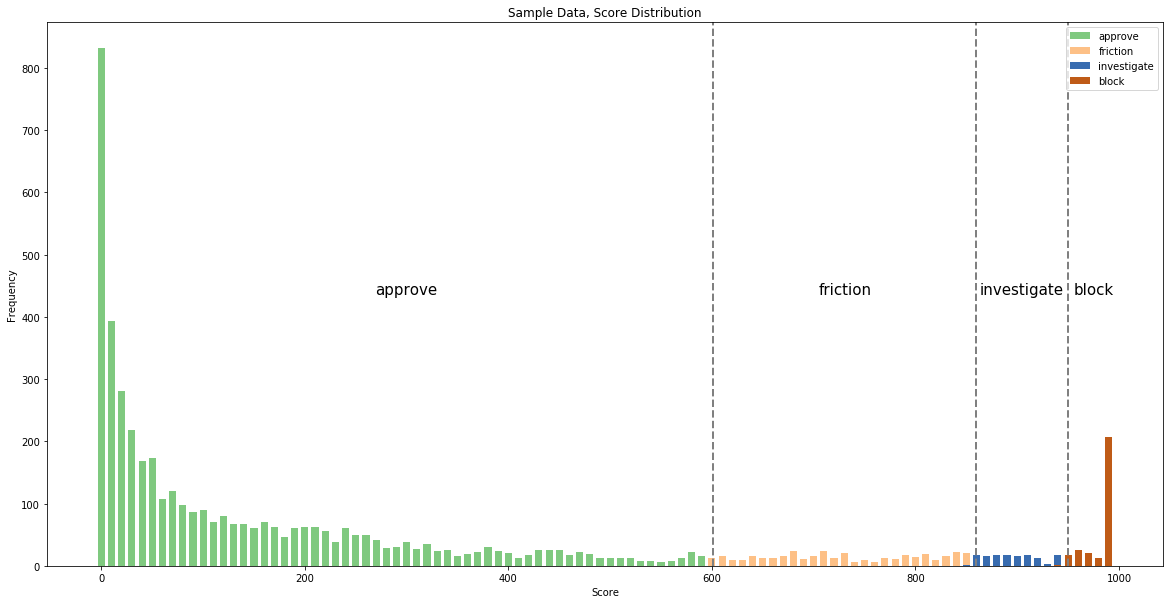

-- rules --
$transaction_fraud_model1_tfi_insightscore >= 950 - block
$transaction_fraud_model1_tfi_insightscore >= 860 and $transaction_fraud_model1_tfi_insightscore < 950 - investigate
$transaction_fraud_model1_tfi_insightscore >= 600 and $transaction_fraud_model1_tfi_insightscore < 860 - friction
$transaction_fraud_model1_tfi_insightscore < 600 - approve


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# -- check score distribution --
predictions['score_bin'] = pd.cut(predictions['score'], 100, labels= list(range(0,1000,10)))
predictions['score_outcome'] = [o[0] for o in predictions['outcomes']]
ctab = pd.crosstab(predictions['score_bin'], predictions['score_outcome']).reset_index()
outcome_ordered = pd.DataFrame(predictions.groupby(['score_outcome']).agg({'score':['mean', 'min','max']}))
outcome_ordered.columns = ['avg_score','min_score','max_score']
outcome_ordered = outcome_ordered.sort_values(by = 'avg_score').reset_index()

plt.figure(figsize=(20,10))
cm = plt.cm.Accent
for i,oc in enumerate(outcome_ordered['score_outcome']):
    plt.bar(ctab['score_bin'], ctab[oc], width=7, color = cm(i/outcome_ordered.shape[0]), label = oc)
    plt.text((outcome_ordered['min_score'][i] + outcome_ordered['max_score'][i])/2, plt.axis()[3]*0.5, oc, ha="center", fontsize=15)
    if i != 0:
        plt.axvline(x=(outcome_ordered['min_score'][i] + outcome_ordered['max_score'][i-1])/2, ls='--', linewidth = 2, c='grey')
        
plt.legend(loc="upper right")
plt.title("Sample Data, Score Distribution")
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# -- check rules defined --
print("-- rules --")
rules = client.get_detector_version(detectorId = DETECTOR_NAME, detectorVersionId = DETECTOR_VER)['rules']
for r in rules:
    res = client.get_rules(detectorId = DETECTOR_NAME, ruleId = r['ruleId'], ruleVersion = r['ruleVersion'])
    print( res['ruleDetails'][0]['expression'], '-', res['ruleDetails'][0]['outcomes'][0])
    

### Take a look at your prediction outcomes
-----
Let's check the model performance and the potential impact from actions.

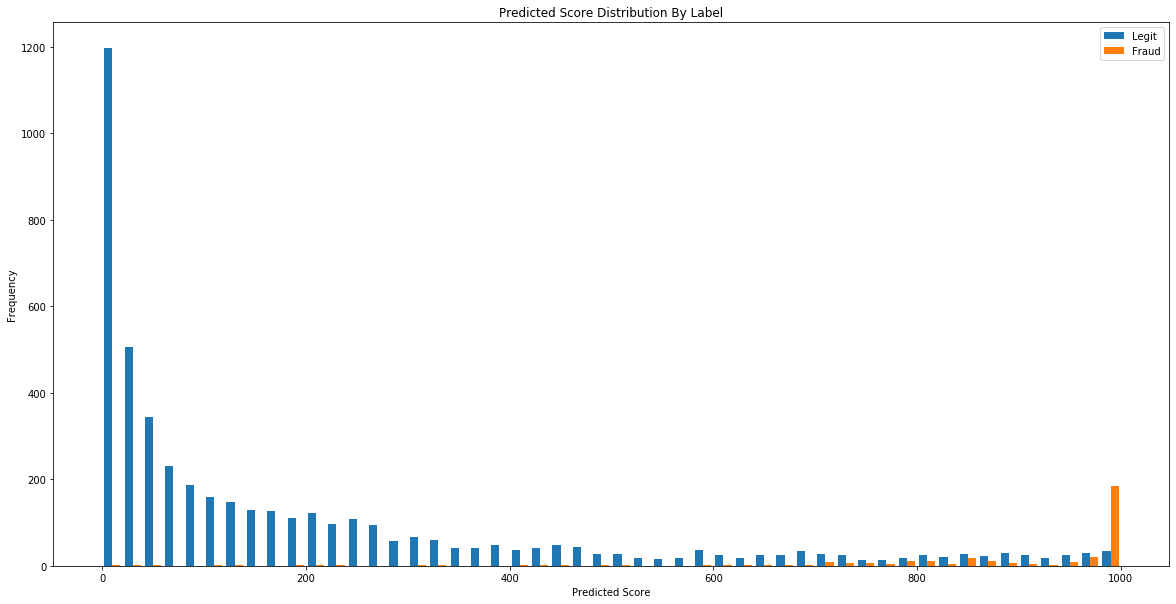

In [26]:
# -- check the distribution by Label --
plt.figure(figsize=(20,10))
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
plt.hist([predict_recs[predict_recs[LABEL_COL]==0]['score'], 
          predict_recs[predict_recs[LABEL_COL]==1]['score']], bins = 50)
plt.legend(["Legit", "Fraud"])
plt.title("Predicted Score Distribution By Label")
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.text
plt.show()

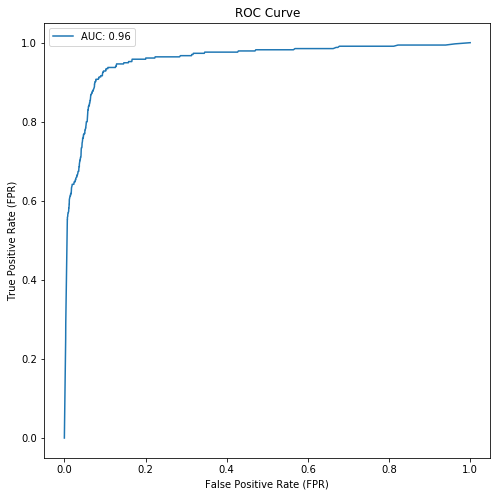

In [27]:
# -- check AUC --
fpr, tpr, threshold = roc_curve(predictions[LABEL_COL],predictions['score'])
test_auc = auc(fpr,tpr)

fig = plt.figure(figsize=(8,8))
plt.plot(fpr,tpr,label=f"AUC: {test_auc:.2f}")
plt.title("ROC Curve")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (FPR)')
plt.legend()
plt.show()

In [28]:
predictions['outcomes'] = predictions['outcomes'].astype(str)
pred_summary = predictions.groupby(['outcomes'])['score'].agg(['mean', 'count']).reset_index()
pred_summary['pct_total'] = pred_summary['count']/predictions.shape[0]
pred_summary

,outcomes,mean,count,pct_total
0,['approve'],126.995011,4209,0.8418
1,['block'],989.319298,285,0.0570
2,['friction'],736.367568,370,0.0740
3,['investigate'],901.786765,136,0.0272


Confusion Matrix by Outcomes:


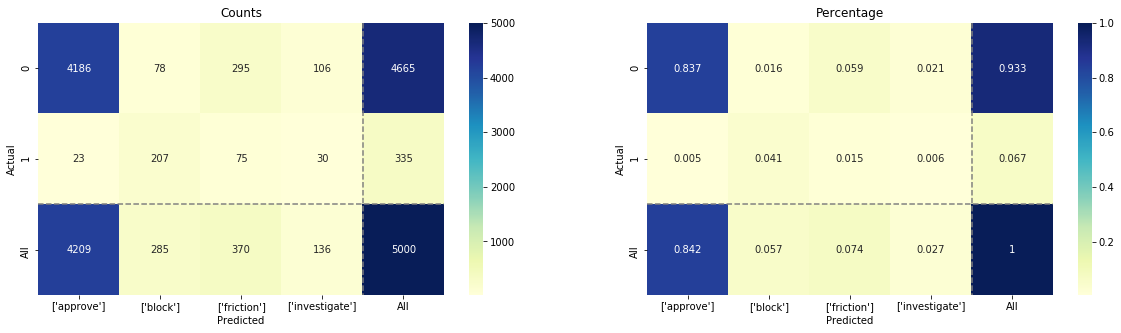

In [29]:
def model_confusion_matrix(predictions):
     
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    
    print("Confusion Matrix by Outcomes:")
    confusion_matrix = pd.crosstab(predictions[LABEL_COL], predictions['outcomes'].astype(str), margins=True, rownames=['Actual'], colnames=['Predicted'])
    confusion_matrix_pct = pd.crosstab(predictions[LABEL_COL], predictions['outcomes'].astype(str), normalize="all", margins=True,rownames=['Actual'], colnames=['Predicted']).round(3)
    sns.heatmap(confusion_matrix, annot=True, fmt='g',cmap="YlGnBu", ax=ax1)
    sns.heatmap(confusion_matrix_pct, annot=True, fmt='g',cmap="YlGnBu", ax=ax2)
 
    ax1.title.set_text('Counts')
    ax2.title.set_text('Percentage')
    
    cnt_actual = len(set(predictions[LABEL_COL]))
    cnt_outcome = len(set(predictions['outcomes']))
    ax1.hlines([cnt_actual], *ax2.get_xlim(), color = 'grey', ls ='--')
    ax1.vlines([cnt_outcome], *ax2.get_xlim(), color = 'grey', ls ='--')
    ax2.hlines([cnt_actual], *ax2.get_xlim(), color = 'grey', ls ='--')
    ax2.vlines([cnt_outcome], *ax2.get_xlim(), color = 'grey', ls ='--')
    plt.show()
    
    
model_confusion_matrix(predictions)

###  Write Predictions to File

-----
Writing out predictions to a file allows you to analyze with other tools like QuickSight 

```python

# -- optionally write predictions to a CSV file -- 
predictions.to_csv(FILE + ".csv", index=False)
# -- or to a XLS file 
predictions.to_excel(FILE + ".xlsx", index=False)

```